In [1]:
import os
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

print('Numpy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Tensorflow version: {}'.format(tf.__version__))


Numpy version: 1.15.4
Pandas version: 0.23.4
Tensorflow version: 1.12.0


#Brainstorm for Kaggle:

1. Convert color to grayscale (wide variety of color balances in the image) Or maybe just setup weight matrices to determine a linear mapping from three channels to one channel [dimensionality reduction]

2. Spatial transformer network before convolution [spatial attention mechanism]

3. Fine grained spatial attention layer, measure each pixel's importance to a neural network's classification accuracy and weight those groups of pixels when you see them together, much in the way a region proposal or mask alignment layer is done [spatial attention mechanism]

4. [Affine spatial transformer] In other words, the original spatial transformer.

5. Color space transformer, since images are B&W and color of varying color balances, why not allow the transformer to also choose the color space?

In [2]:
# Path to the dataset
print(os.listdir("dataset"))


['train.csv', 'sample_submission.csv', 'test', 'train']


In [3]:
training_df = pd.read_csv('dataset/train.csv')
submissions_df = pd.read_csv('dataset/sample_submission.csv')

print('Training Dataframe Head')
training_df.head(10)


Training Dataframe Head


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
6,000a6daec.jpg,w_dd88965
7,000f0f2bf.jpg,new_whale
8,0016b897a.jpg,w_64404ac
9,001c1ac5f.jpg,w_a6f9d33


In [4]:
# Training data Id description
print(training_df['Id'].describe())

count         25361
unique         5005
top       new_whale
freq           9664
Name: Id, dtype: object


# Data Observations

## Challenges
* There are 9664 samples of class new_whale
* 5005 classes and 25361 data samples

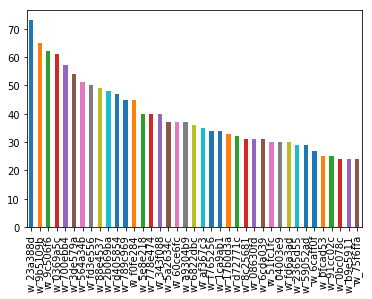

In [5]:
# Top-most frequent classes except for new_whale
training_df['Id'].value_counts()[1:40].plot(kind='bar')


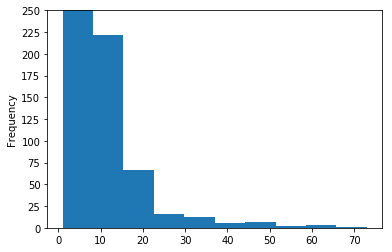

In [6]:
# Bottom-most frequent classes except for new_whale
Y_LIM = 250
Y_TICKS = 10
training_df['Id'].value_counts(ascending=True)[:-1].plot(
    kind='hist', 
    yticks=range(0, Y_LIM+1, int(Y_LIM/Y_TICKS)),
    ylim=[0, Y_LIM]
)

# Data Observations

## Histogram
* Over 4500 classes have only one training sample! (the y-limit is set at 250) Either data augmentation or input weighting would be necessary to balance the data set.
* With such little data, this is almost a template matching algorithm. Perhaps, a cue of these hand engineered features should be taken from this branch of computer vision:
	* Feature descriptors
	* Facial landmark detection
	* Fingerprint detection
* At least a spatial transformer network should be used to align the whale flukes for the convolution layers to then process.

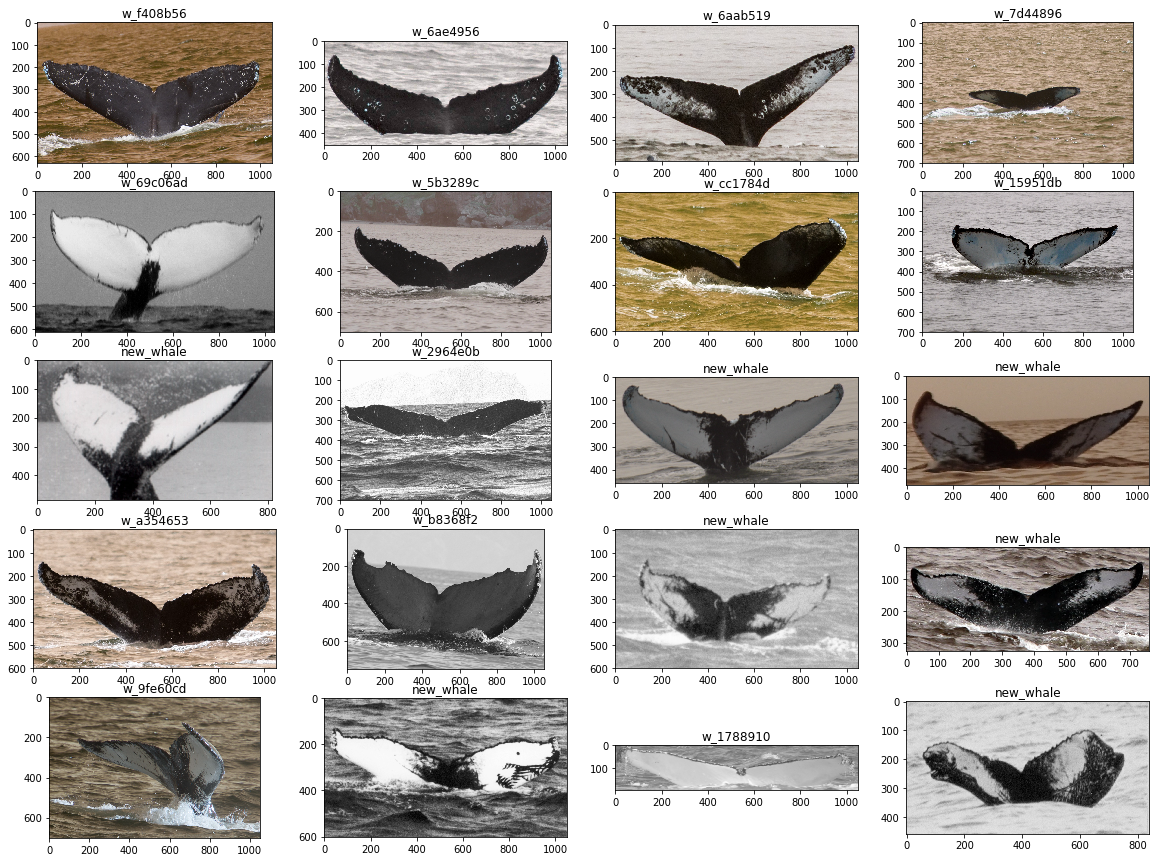

In [8]:
# Display a few random samples
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 3*rows))
    for i in range(columns*rows):
        rand_i = np.random.randint(training_df['Id'].describe()['count'])
        image_path = df.loc[rand_i,'Image']
        image_id = df.loc[rand_i,'Id']
        img = cv2.imread(f'dataset/train/{image_path}')
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

display_samples(training_df, rows=5)

In [8]:
# There's a duplicate in the training set
print(training_df['Image'].loc[training_df['Image'] == '7f7a63b8a.jpg'])
print(training_df['Image'].loc[training_df['Image'] == '60a3f2422.jpg'])

12618    7f7a63b8a.jpg
Name: Image, dtype: object
9542    60a3f2422.jpg
Name: Image, dtype: object


In [10]:
# They're both of the same class
print('Label: {}'.format(training_df['Id'][12618]))
print('Label: {}'.format(training_df['Id'][9542]))


Label: w_7a8ce16
Label: w_7a8ce16


In [11]:
# This class has 6 images in the total class
print('Label has {} counts'.format(training_df.Id.value_counts()['w_7a8ce16']))
print('Label has {} counts'.format(training_df.Id.value_counts()['new_whale']))

Label has 6 counts
Label has 9664 counts


In [12]:
# Prepare dataset


In [2]:
from preprocessing import FlattenPreprocessor

F = FlattenPreprocessor()